<a href="https://colab.research.google.com/github/HyeonuJeong/Mycakd5/blob/main/%EC%BB%A8%EB%B3%BC%EB%A3%A8%EC%85%94%EB%84%90_%EB%B3%80%EC%9D%B4%ED%98%95_%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이미지 생성 모델

- 이미지 잠재 공간에서 샘플링하여 완전히 새로운 이미지나 기존 이미지를 변형시키는 방식의 주요 기법
  - 변이형 오토인코더(Variational AutoEncoders, VAE)
  
  - 적대적 생성 네트워크(Generative Adversarial Networks, GAN)

- 잠재 공간의 한 포인트를 입력으로 받아 이미지(픽셀의 그리드)를 출력하는 모듈을 VAE에서는 디코더(decoder)라고 함

- 수학적으로 AutoEncoder와 Variational AutoEncoder는 전혀 관계가 없다.
AutoEncoder의 목적은 Manifold Learning인 반면 Variational AutoEncoder는 Generative Model이다. 공교롭게도 그 구조를 보니 AE와 같은 것일 뿐임.
매니폴드는 고차원의 데이터, 즉, training DB의 데이터 그 자체를 error없이 잘 표현하는 subspace를 의미


## 잠재 공간(Latent Space)

<img src="https://images.deepai.org/converted-papers/2007.08383/x1.png">

<sub>[이미지 출처] https://deepai.org/publication/deep-learning-in-protein-structural-modeling-and-design</sub>


# 변이형 오토인코더(Variational AutoEncoders, VAE)

VAE란 : https://process-mining.tistory.com/161


- 입력 이미지를 잠재 공간의 고정된 코딩으로 압축하는 대신  
  이미지를 어떤 통계 분포의 파라미터로 변환 
  
- 평균과 분산 파라미터를 사용하여 이 분포에서 무작위로 하나의 샘플을 추출

- 해당 샘플을 디코딩하여 원본 입력으로 복원

- 위 과정은 안정성을 향상, 잠재 공간 어디에서든 의미있는 표현을 인코딩하게 함

  <img src="https://image.slidesharecdn.com/variationalautoencoder-170601084514/95/variational-autoencoder-21-638.jpg?cb=1496306885">

  <sub>[이미지 출력] https://www.slideshare.net/ssuser06e0c5/variational-autoencoder-76552518</sub>

  <br>

- VAE의 훈련

  - 디코딩된 샘플이 원본 입력과 동일하도록 만드는 재구성 손실(reconstruction loss)

  - 잠재 공간을 잘 형성하고 훈련 데이터에 과적합을 줄이는 규제 손실(regularization loss)

- VAE 구현의 pseudocode

      z_mean, z_log_var = encoder(input_img)
      
      z = z_mean + exp(0.5 * z_log_var) * epsilon

      recontructed_img = decoder(z)

      model = Model(input_img, reconstructed_img)

      재구성 손실과 규제 손실을 사용하여 훈련


Variational autoencoder란
https://process-mining.tistory.com/161


## 손실 함수 및 최적화 프로그램 정의

- VAE는 한계 로그 우도에서 증거 하한 (ELBO)을 최대화하여 학습<br>
우리가 원하는 것은 log(p(x)) 값의 최적화이기 때문에 EBLO(Φ) + KL에서 ELBO(Φ)의 값을 최적화

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

- 실제로 우리는이 기대치의 단일 샘플 Monte Carlo 추정치를 최적화

$$\log p(x| z) + \log p(z) - \log q(z|x),$$

몬테카를로 시뮬레이션이란 알려지지 않은 값을 추론적 통계(inferential statistics)방법을 이용해 추정하는 것을 의미합니다. 추론적 통계에서 중요한 개념은 모집단(population)과 샘플(sample)입니다.


In [2]:
!pip install tensorflow-probability


In [3]:

# to generate gifs
!pip install imageio


In [4]:

!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-pk2fwjg5
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-pk2fwjg5
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179891 sha256=daf54e202bf0cc5c6822708642ca8f0f19880929dfb4624fdb1dd90e30a9f599
  Stored in directory: /tmp/pip-ephem-wheel-cache-xn1r_odp/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [5]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [6]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [7]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [8]:
train_size = 60000
batch_size = 32
test_size = 10000

In [9]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

In [10]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [11]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [12]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [13]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [14]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [15]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -156.46585083007812, time elapse for current epoch: 4.854950904846191


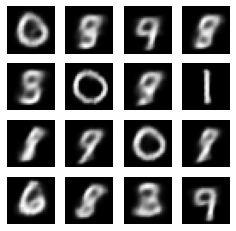

In [16]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

In [17]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

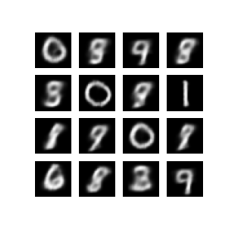

In [18]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

In [19]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)